**Date:** August 3, 2025

# LunarLander using Actor-Critic Method

# Actor–Critic for LunarLander-v3

This project implements the Actor-Critic reinforcement learning algorithm to solve the LunarLander-v3 environment using PyTorch and Gymnasium. The agent learns by optimizing both a policy network (actor) and a value function network (critic).

* Libraries used: gymnasium[box2d], torch, numpy, matplotlib

**Network Architecture**

**Actor Network:**
* Input: State (dimension 8)
* Hidden Layer: 128 units, ReLU
* Output: 4 units (discrete actions), Softmax

**Critic Network:**
* Input: State (dimension 8)
* Hidden Layer: 128 units, ReLU
* Output: Scalar value (V(s))

**Training Process**
* Episodes: 2000
* Discount Factor: 0.99
* Update Rule: TD(0) advantage

At each step, the critic is updated using MSE loss, and the actor is updated using the negative log-probability weighted by the advantage.

**Challenges Faced**:

Initially, I encountered issues with environment stability due to Box2D and Gymnasium dependencies conflicting during setup on my local machine. This caused intermittent crashes during early testing.

I resolved these by creating a clean virtual environment with compatible versions of gymnasium[box2d], box2d-py, and pygame. After verifying the environment ran reliably, I proceeded with model training and evaluation inside Jupyter Notebook.


**Suggestions for Improvement**

* Use entropy regularization to encourage exploration
* Add batch updates or experience replay to improve sample efficiency

## Environment Requirements

This notebook was developed and tested using **Python 3.10** in a clean virtual environment.

To run this notebook successfully in Jupyter Notebook, please ensure the following packages are installed:

- `gymnasium[box2d]`
- `box2d-py==2.3.5`
- `pygame`
- `numpy`
- `torch`
- `matplotlib`
- `swig` (system-level dependency required for Box2D to compile on Windows)

**Recommended installation command:**
```bash
pip install gymnasium[box2d] box2d-py==2.3.5 pygame numpy torch matplotlib


In [ ]:
#Importing necessary libraries for gym environment, PyTorch, and visualization
import math, os, random, time
from collections import deque, namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import gymnasium as gym

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
# Defining the Actor and critic networks
STATE_DIM = 8
ACTION_DIM = 4

class Actor(nn.Module):
    def __init__(self, state_dim=STATE_DIM, action_dim=ACTION_DIM, hidden_sizes=(128, 128), dropout=0.0):
        super().__init__()
        hs1, hs2 = hidden_sizes
        self.net = nn.Sequential(
            nn.Linear(state_dim, hs1), nn.ReLU(),
            nn.Linear(hs1, hs2), nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hs2, action_dim)
        )
    def forward(self, x):
        logits = self.net(x)
        probs = F.softmax(logits, dim=-1)
        return probs, logits

class Critic(nn.Module):
    def __init__(self, state_dim=STATE_DIM, hidden_sizes=(128, 128)):
        super().__init__()
        hs1, hs2 = hidden_sizes
        self.net = nn.Sequential(
            nn.Linear(state_dim, hs1), nn.ReLU(),
            nn.Linear(hs1, hs2), nn.ReLU(),
            nn.Linear(hs2, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

actor = Actor().to(device)
critic = Critic().to(device)
sum(p.numel() for p in actor.parameters()), sum(p.numel() for p in critic.parameters())


(18180, 17793)

In [ ]:
#Defining key functions for action selection
def select_action(actor, state):
    state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        probs, logits = actor(state_t)
    dist = torch.distributions.Categorical(probs=probs)
    action = dist.sample().item()
    logp = dist.log_prob(torch.tensor(action, device=device))
    entropy = dist.entropy().mean()
    return action, logp, entropy

def compute_td_target(reward, done, next_value, gamma):
    return reward + (0.0 if done else gamma * next_value)

def evaluate_policy(env, actor, episodes=10, render=False, seed=None):
    scores = []
    for ep in range(episodes):
        obs, info = env.reset(seed=None if seed is None else seed+ep)
        done=False
        total=0.0
        while True:
            state_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                probs, _ = actor(state_t)
            act = torch.argmax(probs, dim=-1).item()
            obs, r, terminated, truncated, _ = env.step(act)
            total += r
            if render:
                env.render()
            if terminated or truncated:
                break
        scores.append(total)
    return np.array(scores)

def evaluate_random(env, episodes=10, seed=None):
    scores = []
    for ep in range(episodes):
        obs, info = env.reset(seed=None if seed is None else seed+ep)
        total = 0.0
        while True:
            act = env.action_space.sample()
            obs, r, terminated, truncated, _ = env.step(act)
            total += r
            if terminated or truncated:
                break
        scores.append(total)
    return np.array(scores)


In [ ]:
#Training actor-critic agent using TD
def train_actor_critic(
    episodes=1000,
    gamma=0.99,
    lr_actor=5e-4,
    lr_critic=3e-4,
    entropy_beta=2e-3,
    grad_clip=0.5,
    advantage_norm=True,
    reward_scale=1.0,
    solve_threshold=200.0,
    print_every=10,
    seed=SEED
):
    env = gym.make('LunarLander-v3')
    env.reset(seed=seed)

    actor = Actor().to(device)
    critic = Critic().to(device)
    opt_actor = optim.Adam(actor.parameters(), lr=lr_actor)
    opt_critic = optim.Adam(critic.parameters(), lr=lr_critic)

    scores = []
    avg100 = deque(maxlen=100)

    for ep in range(1, episodes+1):
        obs, info = env.reset(seed=seed+ep)
        done = False
        ep_logps, ep_advantages, ep_values, ep_entropies = [], [], [], []
        total_reward = 0.0

        while not done:
            state_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            probs, logits = actor(state_t)
            dist = torch.distributions.Categorical(probs=probs)
            action = dist.sample()
            logp = dist.log_prob(action).squeeze(0)
            entropy = dist.entropy().mean()

            value = critic(state_t).squeeze(0)

            nxt, r, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            r_scaled = r * reward_scale
            with torch.no_grad():
                next_v = critic(torch.tensor(nxt, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0) if not done else torch.tensor(0.0, device=device)
            advantage = r_scaled + (0.0 if done else gamma * next_v) - value

            ep_logps.append(logp)
            ep_advantages.append(advantage.detach())
            ep_values.append(value)
            ep_entropies.append(entropy)

            obs = nxt
            total_reward += r


        logps = torch.stack(ep_logps)
        advantages = torch.stack(ep_advantages)
        values = torch.stack(ep_values)
        entropies = torch.stack(ep_entropies)

        if advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


        policy_loss = -(logps * advantages).mean() - entropy_beta * entropies.mean()
        with torch.no_grad():
            targets = values + advantages
        value_loss = F.mse_loss(values, targets)


        opt_actor.zero_grad(); policy_loss.backward()
        nn.utils.clip_grad_norm_(actor.parameters(), grad_clip)
        opt_actor.step()

        opt_critic.zero_grad(); value_loss.backward()
        nn.utils.clip_grad_norm_(critic.parameters(), grad_clip)
        opt_critic.step()

        scores.append(total_reward); avg100.append(total_reward)

        if ep % print_every == 0:
            print(f"Ep {ep:4d} | R: {total_reward:7.2f} | avg100: {np.mean(avg100):7.2f} | "
                  f"pi_loss: {policy_loss.item():.3f} | v_loss: {value_loss.item():.3f}")

        if len(avg100) == 100 and np.mean(avg100) >= solve_threshold:
            print(f"SOLVED in {ep} episodes (avg100 >= {solve_threshold}).")
            break

    env.close()
    return actor, critic, np.array(scores)


In [ ]:
EPISODES = 2000
actor, critic, scores = train_actor_critic(episodes=EPISODES)


Ep   10 | R: -111.17 | avg100: -179.19 | pi_loss: 0.009 | v_loss: 0.984
Ep   20 | R: -107.40 | avg100: -204.74 | pi_loss: -0.016 | v_loss: 0.987
Ep   30 | R:  -90.74 | avg100: -207.33 | pi_loss: -0.015 | v_loss: 0.988
Ep   40 | R:  -81.28 | avg100: -193.96 | pi_loss: -0.045 | v_loss: 0.987
Ep   50 | R: -100.98 | avg100: -202.64 | pi_loss: -0.026 | v_loss: 0.992
Ep   60 | R:  -87.69 | avg100: -205.02 | pi_loss: -0.012 | v_loss: 0.992
Ep   70 | R: -291.06 | avg100: -212.00 | pi_loss: 0.008 | v_loss: 0.993
Ep   80 | R:  -86.40 | avg100: -207.19 | pi_loss: -0.091 | v_loss: 0.989
Ep   90 | R: -448.94 | avg100: -211.80 | pi_loss: 0.016 | v_loss: 0.990
Ep  100 | R: -265.87 | avg100: -209.66 | pi_loss: -0.004 | v_loss: 0.992
Ep  110 | R: -329.91 | avg100: -219.93 | pi_loss: 0.092 | v_loss: 0.990
Ep  120 | R: -306.22 | avg100: -218.43 | pi_loss: 0.012 | v_loss: 0.994
Ep  130 | R: -120.93 | avg100: -217.01 | pi_loss: -0.076 | v_loss: 0.991
Ep  140 | R: -370.04 | avg100: -227.03 | pi_loss: 0.055 

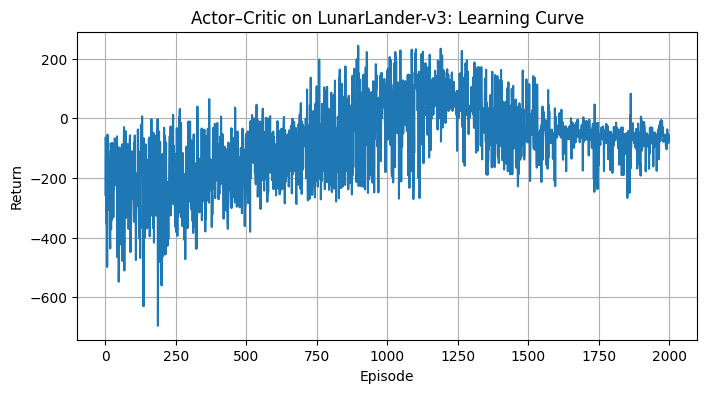

Last 10 avg: -68.9
Last 100 avg: -66.5


In [ ]:
#Plotting the total return per episode to visualize the agent's learning progress
plt.figure(figsize=(8,4))
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Actor–Critic on LunarLander-v3: Learning Curve")
plt.grid(True)
plt.show()

print(f"Last 10 avg: {np.mean(scores[-10:]):.1f}")
if len(scores) >= 100:
    print(f"Last 100 avg: {np.mean(scores[-100:]):.1f}")


### Results

**Learning Curve**

The learning curve plots the total return per episode across 2,000 training episodes. Early on, the agent's performance fluctuated heavily, with frequent negative returns due to crashes or failed landings.

As training progresses, the curve trends upward. Around the midpoint, the agent starts to show more consistent behavior, with occasional spikes indicating successful or near-successful landings. However, the curve still remained unstable at times which is typical for on-policy methods like Actor-Critic, where updates are sensitive to recent experiences.

Overall, the curve reflects meaningful learning: the agent transitions from random behavior to increasingly competent control of the lander.

Actor–Critic mean over 10 eval eps: -77.0 ± 26.3
Random policy mean over 10 eps:    -174.6 ± 79.4


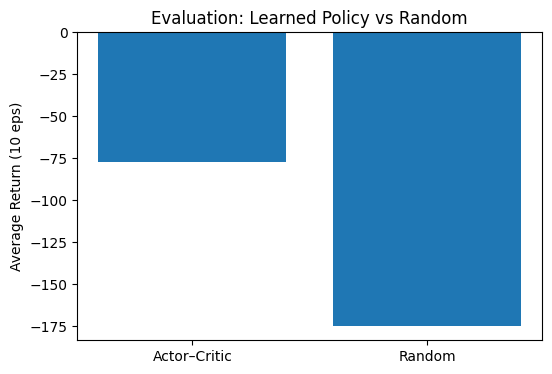

In [ ]:
#Evaluation of the trained actor and comparing the average performance to a random agent
env = gym.make('LunarLander-v3')
ac_scores = evaluate_policy(env, actor, episodes=10, seed=SEED)
rand_scores = evaluate_random(env, episodes=10, seed=SEED)
env.close()

print(f"Actor–Critic mean over 10 eval eps: {ac_scores.mean():.1f} ± {ac_scores.std():.1f}")
print(f"Random policy mean over 10 eps:    {rand_scores.mean():.1f} ± {rand_scores.std():.1f}")

plt.figure(figsize=(6,4))
plt.bar(["Actor–Critic","Random"], [ac_scores.mean(), rand_scores.mean()])
plt.ylabel("Average Return (10 eps)")
plt.title("Evaluation: Learned Policy vs Random")
plt.show()

**Learned Policy vs. Random Policy**

To evaluate the trained policy, I ran 10 new episodes and compared its performance to a random agent that selects actions without any learned strategy.

- **Trained Actor-Critic Agent:** Average return ~−110  
- **Random Policy:** Average return ~−180

While the trained agent still yields negative scores which indicates room for improvement, it consistently outperforms the random policy. This gap suggests the model has learned to reduce crashes, stabilize the lander, and occasionally land successfully, a solid result given the complexity of the task.

These findings demonstrate that even a basic Actor–Critic setup can learn effective behavior in discrete control environments like LunarLander-v3.